# 01 — Data Collection & Panel Dataset

**Goal:** Pull price data, earnings history, and macro regime data for the full S&P 500. 
Merge everything into one flat panel dataset where **each row = one earnings event**.

**Data Sources:**
- `yfinance` — Price/Volume, ^TNX (10Y Yield), ^VIX
- `yfinance` earnings history — EPS Actual vs Estimate (proxy for Capital IQ)
- *(If you have Capital IQ access, swap in true consensus dispersion for SUE)*

**Output:** `data/panel_dataset.csv`

In [32]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import yfinance as yf
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# ── Patched functions (fixes yfinance column name + timezone issues) ──

def get_price_data(ticker, start="2019-01-01", end=None):
    try:
        t = yf.Ticker(ticker)
        df = t.history(start=start, end=end, auto_adjust=True)
        if df.empty or len(df) < 60:
            return None
        df.index = pd.to_datetime(df.index)
        if df.index.tzinfo is not None:
            df.index = df.index.tz_convert('America/New_York').tz_localize(None)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        return df.sort_index()
    except Exception as e:
        return None

def get_spx_returns(start="2019-01-01", end=None):
    spx = get_price_data("^GSPC", start=start, end=end)
    if spx is None:
        return None
    spx['spx_ret'] = spx['close'].pct_change()
    return spx[['close', 'spx_ret']].rename(columns={'close': 'spx_close'})

def get_earnings_history(ticker):
    try:
        t = yf.Ticker(ticker)
        cal = t.get_earnings_dates(limit=40)
        if cal is None or cal.empty:
            return None
        cal = cal.copy()
        cal.index = pd.to_datetime(cal.index)
        if cal.index.tzinfo is not None:
            cal.index = cal.index.tz_convert('America/New_York').tz_localize(None)
        cal = cal.sort_index()
        cal = cal.rename(columns={
            'Reported EPS': 'eps_actual',
            'EPS Estimate':  'eps_est',
            'Surprise(%)':   'surprise_pct'
        })
        cal = cal.dropna(subset=['eps_actual'])
        cal['eps_surprise']     = cal['eps_actual'] - cal['eps_est']
        cal['eps_std']          = cal['eps_surprise'].rolling(4, min_periods=2).std().shift(1)
        cal['sue']              = (cal['eps_surprise'] / (cal['eps_std'].abs() + 1e-9)).clip(-10, 10)
        cal['eps_surprise_pct'] = cal['eps_surprise'] / cal['eps_est'].abs().replace(0, np.nan)
        cal['beat']             = (cal['eps_actual'] > cal['eps_est']).astype(int)
        cal['hist_beat_rate']   = cal['beat'].shift(1).rolling(4, min_periods=2).mean()
        def consec_streak(series):
            streaks, count = [], 0
            for v in series:
                count = count + 1 if v == 1 else 0
                streaks.append(count)
            return pd.Series(streaks, index=series.index)
        cal['beat_streak'] = consec_streak(cal['beat'].shift(1).fillna(0))
        return cal
    except Exception as e:
        print(f"Error {ticker}: {e}")
        return None

def get_sp500_tickers():
    tickers_sectors = {
        'AAPL': 'Information Technology', 'MSFT': 'Information Technology',
        'NVDA': 'Information Technology', 'GOOGL': 'Communication Services',
        'META': 'Communication Services', 'AMZN': 'Consumer Discretionary',
        'TSLA': 'Consumer Discretionary', 'AMD': 'Information Technology',
        'INTC': 'Information Technology', 'CRM': 'Information Technology',
        'ORCL': 'Information Technology', 'ADBE': 'Information Technology',
        'QCOM': 'Information Technology', 'TXN': 'Information Technology',
        'AVGO': 'Information Technology', 'JPM': 'Financials',
        'BAC': 'Financials', 'WFC': 'Financials', 'GS': 'Financials',
        'MS': 'Financials', 'BLK': 'Financials', 'AXP': 'Financials',
        'SCHW': 'Financials', 'C': 'Financials', 'USB': 'Financials',
        'JNJ': 'Health Care', 'UNH': 'Health Care', 'PFE': 'Health Care',
        'ABBV': 'Health Care', 'MRK': 'Health Care', 'TMO': 'Health Care',
        'ABT': 'Health Care', 'DHR': 'Health Care', 'BMY': 'Health Care',
        'LLY': 'Health Care', 'WMT': 'Consumer Staples',
        'PG': 'Consumer Staples', 'KO': 'Consumer Staples',
        'PEP': 'Consumer Staples', 'COST': 'Consumer Staples',
        'MCD': 'Consumer Discretionary', 'NKE': 'Consumer Discretionary',
        'SBUX': 'Consumer Discretionary', 'TGT': 'Consumer Staples',
        'HD': 'Consumer Discretionary', 'XOM': 'Energy', 'CVX': 'Energy',
        'COP': 'Energy', 'SLB': 'Energy', 'EOG': 'Energy',
        'CAT': 'Industrials', 'BA': 'Industrials', 'HON': 'Industrials',
        'UPS': 'Industrials', 'RTX': 'Industrials', 'GE': 'Industrials',
        'MMM': 'Industrials', 'LMT': 'Industrials', 'DE': 'Industrials',
        'FDX': 'Industrials', 'NEE': 'Utilities', 'DUK': 'Utilities',
        'SO': 'Utilities', 'AMT': 'Real Estate', 'PLD': 'Real Estate',
        'VZ': 'Communication Services', 'T': 'Communication Services',
        'NFLX': 'Communication Services', 'DIS': 'Communication Services',
    }
    return list(tickers_sectors.keys()), tickers_sectors

from utils.helpers import (
    get_macro_data, compute_technical_features,
    compute_ticker_history_features, compute_targets, compute_magnitude_class
)

os.makedirs('../data', exist_ok=True)
os.makedirs('../outputs', exist_ok=True)
print("✓ All functions loaded and patched")

✓ All functions loaded and patched


In [33]:
# ── Configuration ──────────────────────────────────────────────
START_DATE     = '2019-01-01'
END_DATE       = '2024-12-31'
POST_DAYS      = 5       # hold period for return calculation
PRE_WINDOW     = 30      # trading days of pre-earnings price history
MIN_PRICE      = 5.0     # skip penny stocks
MAX_TICKERS    = 100     # set to None for full S&P 500 (takes ~45 min)

print(f'Date range : {START_DATE} → {END_DATE}')
print(f'Post-earnings hold : {POST_DAYS} days')
print(f'Tickers    : {"All S&P 500" if MAX_TICKERS is None else MAX_TICKERS} (for testing)')

Date range : 2019-01-01 → 2024-12-31
Post-earnings hold : 5 days
Tickers    : 100 (for testing)


In [34]:
# ── Step 1: Load macro data (rates + VIX) ─────────────────────
print('Downloading macro data (^TNX, ^VIX)...')
macro = get_macro_data(start=START_DATE, end=END_DATE)
print(f'Macro data shape: {macro.shape}')
macro.head()

Macro data shape: (1509, 6)


,tnx,vix,rate_regime,vix_regime,tnx_1m_chg,vix_5d_chg
Date,,,,,,
2019-01-02 01:00:00,2.661,23.219999,1,1,NaN,NaN
2019-01-03 01:00:00,2.554,25.450001,1,1,NaN,NaN
2019-01-04 01:00:00,2.659,21.379999,1,1,NaN,NaN
2019-01-07 01:00:00,2.682,21.400000,1,1,NaN,NaN
2019-01-08 01:00:00,2.716,20.469999,1,1,NaN,NaN


In [35]:
# def get_price_data(ticker, start="2019-01-01", end=None):
#     try:
#         t = yf.Ticker(ticker)
#         df = t.history(start=start, end=end, auto_adjust=True)
#         if df.empty or len(df) < 60:
#             return None
#         # Fix: convert timezone then strip it
#         df.index = df.index.tz_convert('America/New_York').tz_localize(None)
#         df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
#         df.columns = ['open', 'high', 'low', 'close', 'volume']
#         return df.sort_index()
#     except Exception as e:
#         print(f"Error getting price data for {ticker}: {e}")
#         return None

# def get_spx_returns(start="2019-01-01", end=None):
#     spx = get_price_data("^GSPC", start=start, end=end)
#     if spx is None:
#         return None
#     spx['spx_ret'] = spx['close'].pct_change()
#     return spx[['close', 'spx_ret']].rename(columns={'close': 'spx_close'})

# print("Functions overridden — now re-run from Step 1 (macro data) downward")

In [36]:
# ── Step 2: Load S&P 500 returns for alpha calculation ─────────
print('Downloading S&P 500 index returns...')
spx = get_spx_returns(start=START_DATE, end=END_DATE)
print(f'SPX data shape: {spx.shape}')

SPX data shape: (1509, 2)


In [37]:
# ── Step 3: Get ticker universe ────────────────────────────────
print('Fetching S&P 500 tickers...')

def get_sp500_tickers():
    """Hardcoded list of S&P 500 tickers with sectors."""
    tickers_sectors = {
        # Technology
        'AAPL': 'Information Technology', 'MSFT': 'Information Technology',
        'NVDA': 'Information Technology', 'GOOGL': 'Communication Services',
        'META': 'Communication Services', 'AMZN': 'Consumer Discretionary',
        'TSLA': 'Consumer Discretionary', 'AMD': 'Information Technology',
        'INTC': 'Information Technology', 'CRM': 'Information Technology',
        'ORCL': 'Information Technology', 'ADBE': 'Information Technology',
        'QCOM': 'Information Technology', 'TXN': 'Information Technology',
        'AVGO': 'Information Technology',
        # Financials
        'JPM': 'Financials', 'BAC': 'Financials', 'WFC': 'Financials',
        'GS': 'Financials', 'MS': 'Financials', 'BLK': 'Financials',
        'AXP': 'Financials', 'SCHW': 'Financials', 'C': 'Financials',
        'USB': 'Financials',
        # Healthcare
        'JNJ': 'Health Care', 'UNH': 'Health Care', 'PFE': 'Health Care',
        'ABBV': 'Health Care', 'MRK': 'Health Care', 'TMO': 'Health Care',
        'ABT': 'Health Care', 'DHR': 'Health Care', 'BMY': 'Health Care',
        'LLY': 'Health Care',
        # Consumer
        'WMT': 'Consumer Staples', 'PG': 'Consumer Staples',
        'KO': 'Consumer Staples', 'PEP': 'Consumer Staples',
        'COST': 'Consumer Staples', 'MCD': 'Consumer Discretionary',
        'NKE': 'Consumer Discretionary', 'SBUX': 'Consumer Discretionary',
        'TGT': 'Consumer Staples', 'HD': 'Consumer Discretionary',
        # Energy
        'XOM': 'Energy', 'CVX': 'Energy', 'COP': 'Energy',
        'SLB': 'Energy', 'EOG': 'Energy',
        # Industrials
        'CAT': 'Industrials', 'BA': 'Industrials', 'HON': 'Industrials',
        'UPS': 'Industrials', 'RTX': 'Industrials', 'GE': 'Industrials',
        'MMM': 'Industrials', 'LMT': 'Industrials', 'DE': 'Industrials',
        'FDX': 'Industrials',
        # Utilities / Real Estate
        'NEE': 'Utilities', 'DUK': 'Utilities', 'SO': 'Utilities',
        'AMT': 'Real Estate', 'PLD': 'Real Estate',
        # Communication
        'VZ': 'Communication Services', 'T': 'Communication Services',
        'NFLX': 'Communication Services', 'DIS': 'Communication Services',
    }
    tickers = list(tickers_sectors.keys())
    sectors = tickers_sectors
    return tickers, sectors

all_tickers, sector_map = get_sp500_tickers()


tickers = all_tickers[:MAX_TICKERS] if MAX_TICKERS else all_tickers
print(f'Tickers loaded: {len(tickers)}')

Fetching S&P 500 tickers...
Tickers loaded: 69


In [38]:
# ── Step 4: Main loop — build one row per earnings event ───────
records = []
skipped = []

for ticker in tqdm(tickers, desc='Processing tickers'):
    
    # --- Price data ---
    price = get_price_data(ticker, start=START_DATE, end=END_DATE)
    if price is None or price['close'].iloc[-1] < MIN_PRICE:
        skipped.append((ticker, 'no price data'))
        continue

    # --- Earnings history ---
    earn = get_earnings_history(ticker)
    if earn is None or len(earn) < 4:
        skipped.append((ticker, 'insufficient earnings history'))
        continue

    # Filter to our date range
    earn = earn[(earn.index >= START_DATE) & (earn.index <= END_DATE)]
    if len(earn) < 2:
        skipped.append((ticker, 'no earnings in date range'))
        continue

    # --- Per-event feature extraction ---
    all_earn_dates = earn.index.tolist()

    for earn_date in all_earn_dates:
        try:
            # Pre-earnings price window
            pre = price[price.index < earn_date].tail(PRE_WINDOW)
            if len(pre) < 20:
                continue
            prev_close = pre.iloc[-1]['close']

            # Post-earnings return (stock)
            post = price[price.index > earn_date]
            if len(post) < POST_DAYS:
                continue
            post_close   = post.iloc[POST_DAYS - 1]['close']
            stock_ret_5d = post_close / prev_close - 1

            # Post-earnings return (S&P 500) — same window
            spx_window = spx[
                (spx.index > earn_date)
            ].head(POST_DAYS)
            if len(spx_window) < POST_DAYS:
                continue
            spx_ret_5d = (
                spx_window.iloc[-1]['spx_close'] /
                spx_window.iloc[0]['spx_close'] - 1
            )

            # Target variables
            target_binary, excess_ret = compute_targets(stock_ret_5d, spx_ret_5d)
            target_mag = compute_magnitude_class(excess_ret)

            # Macro regime on earnings date
            macro_on_date = macro[macro.index <= earn_date]
            if macro_on_date.empty:
                continue
            macro_row = macro_on_date.iloc[-1]

            # Technical features
            tech = compute_technical_features(pre)

            # Ticker historical earnings behavior
            past_dates = [d for d in all_earn_dates if d < earn_date]
            hist_feats = compute_ticker_history_features(price, past_dates)

            # Earnings surprise row
            earn_row = earn.loc[earn_date]

            # Assemble record
            row = {
                # Identifiers
                'ticker':         ticker,
                'earn_date':      earn_date,
                'sector':         sector_map.get(ticker, 'Unknown'),
                'quarter':        earn_date.quarter,
                'year':           earn_date.year,

                # Targets
                'target_binary':  target_binary,
                'target_mag':     target_mag,
                'stock_ret_5d':   stock_ret_5d,
                'spx_ret_5d':     spx_ret_5d,
                'excess_ret_5d':  excess_ret,

                # Earnings surprise signals
                'sue':              earn_row.get('sue', np.nan),
                'eps_surprise_pct': earn_row.get('eps_surprise_pct', np.nan),
                'hist_beat_rate':   earn_row.get('hist_beat_rate', np.nan),
                'beat_streak':      earn_row.get('beat_streak', np.nan),

                # Macro regime
                'tnx':              macro_row['tnx'],
                'vix':              macro_row['vix'],
                'rate_regime':      macro_row['rate_regime'],
                'vix_regime':       macro_row['vix_regime'],
                'tnx_1m_chg':       macro_row['tnx_1m_chg'],
                'vix_5d_chg':       macro_row['vix_5d_chg'],
            }

            # Add technical features
            row.update(tech)
            # Add historical behavior features
            row.update(hist_feats)

            records.append(row)

        except Exception as e:
            continue  # skip malformed events silently

print(f'\nTotal events collected : {len(records)}')
print(f'Tickers skipped        : {len(skipped)}')

Processing tickers:   0%|          | 0/69 [00:00<?, ?it/s]


Total events collected : 1611
Tickers skipped        : 0


Debugging 1

In [39]:
# # Test a single ticker to see what's going wrong
# import yfinance as yf

# test_ticker = 'AAPL'
# t = yf.Ticker(test_ticker)

# # Check earnings dates
# print("=== Earnings dates ===")
# earn = t.get_earnings_dates(limit=20)
# print(earn)
# print("\nType:", type(earn))
# print("Empty?", earn is None or earn.empty)

In [40]:
# # Check price data
# price = t.history(start='2019-01-01', auto_adjust=True)
# print("=== Price data ===")
# print(price.head(3))
# print("\nIndex type:", type(price.index[0]))
# print("Index tz:", price.index.tzinfo)

In [41]:
# print("Records collected:", len(records))
# print("Skipped:", len(skipped))
# print("\nSkip reasons:")
# for s in skipped[:15]:
#     print(s)

In [42]:
# from utils.helpers import get_earnings_history

# earn = get_earnings_history('AAPL')
# print("Type:", type(earn))
# print("Length:", len(earn) if earn is not None else "None")
# print("\n", earn)

In [43]:
# t = yf.Ticker('AAPL')
# raw = t.get_earnings_dates(limit=20)
# print(raw)
# print("\nColumns:", raw.columns.tolist())

In [44]:
# def get_earnings_history(ticker):
#     try:
#         t = yf.Ticker(ticker)
#         cal = t.get_earnings_dates(limit=40)
#         if cal is None or cal.empty:
#             return None

#         cal = cal.copy()
#         cal.index = pd.to_datetime(cal.index).tz_convert('America/New_York').tz_localize(None)
#         cal = cal.sort_index()

#         # Rename to match actual yfinance column names
#         cal = cal.rename(columns={
#             'Reported EPS':  'eps_actual',
#             'EPS Estimate':  'eps_est',
#             'Surprise(%)':   'surprise_pct'
#         })

#         # Keep only rows where actual result is known
#         cal = cal.dropna(subset=['eps_actual'])

#         # Raw surprise
#         cal['eps_surprise'] = cal['eps_actual'] - cal['eps_est']

#         # Proxy SUE
#         cal['eps_std'] = cal['eps_surprise'].rolling(4, min_periods=2).std().shift(1)
#         cal['sue'] = cal['eps_surprise'] / (cal['eps_std'].abs() + 1e-9)
#         cal['sue'] = cal['sue'].clip(-10, 10)

#         # Surprise as % of estimate
#         cal['eps_surprise_pct'] = (
#             cal['eps_surprise'] / cal['eps_est'].abs().replace(0, np.nan)
#         )

#         # Historical beat rate
#         cal['beat'] = (cal['eps_actual'] > cal['eps_est']).astype(int)
#         cal['hist_beat_rate'] = cal['beat'].shift(1).rolling(4, min_periods=2).mean()

#         # Consecutive beat streak
#         def consec_streak(series):
#             streaks, count = [], 0
#             for v in series:
#                 count = count + 1 if v == 1 else 0
#                 streaks.append(count)
#             return pd.Series(streaks, index=series.index)
#         cal['beat_streak'] = consec_streak(cal['beat'].shift(1).fillna(0))

#         return cal

#     except Exception as e:
#         print(f"Error {ticker}: {e}")
#         return None

# print("Function overridden — testing on AAPL...")
# test = get_earnings_history('AAPL')
# print(f"Rows returned: {len(test)}")
# print(test[['eps_actual', 'eps_est', 'sue', 'hist_beat_rate']].head())

In [45]:
# ── Step 5: Build DataFrame and save ──────────────────────────
panel = pd.DataFrame(records)
panel = panel.sort_values('earn_date').reset_index(drop=True)

print(f'Panel shape: {panel.shape}')
print(f'Date range : {panel["earn_date"].min()} → {panel["earn_date"].max()}')
print(f'Unique tickers: {panel["ticker"].nunique()}')
print(f'\nClass balance (target_binary):')
print(panel['target_binary'].value_counts(normalize=True).round(3))

panel.to_csv('../data/panel_dataset.csv', index=False)
print('\n✓ Saved to data/panel_dataset.csv')

Panel shape: (1611, 35)
Date range : 2019-01-30 06:00:00 → 2024-12-19 16:00:00
Unique tickers: 69

Class balance (target_binary):
target_binary
0    0.508
1    0.492
Name: proportion, dtype: float64

✓ Saved to data/panel_dataset.csv


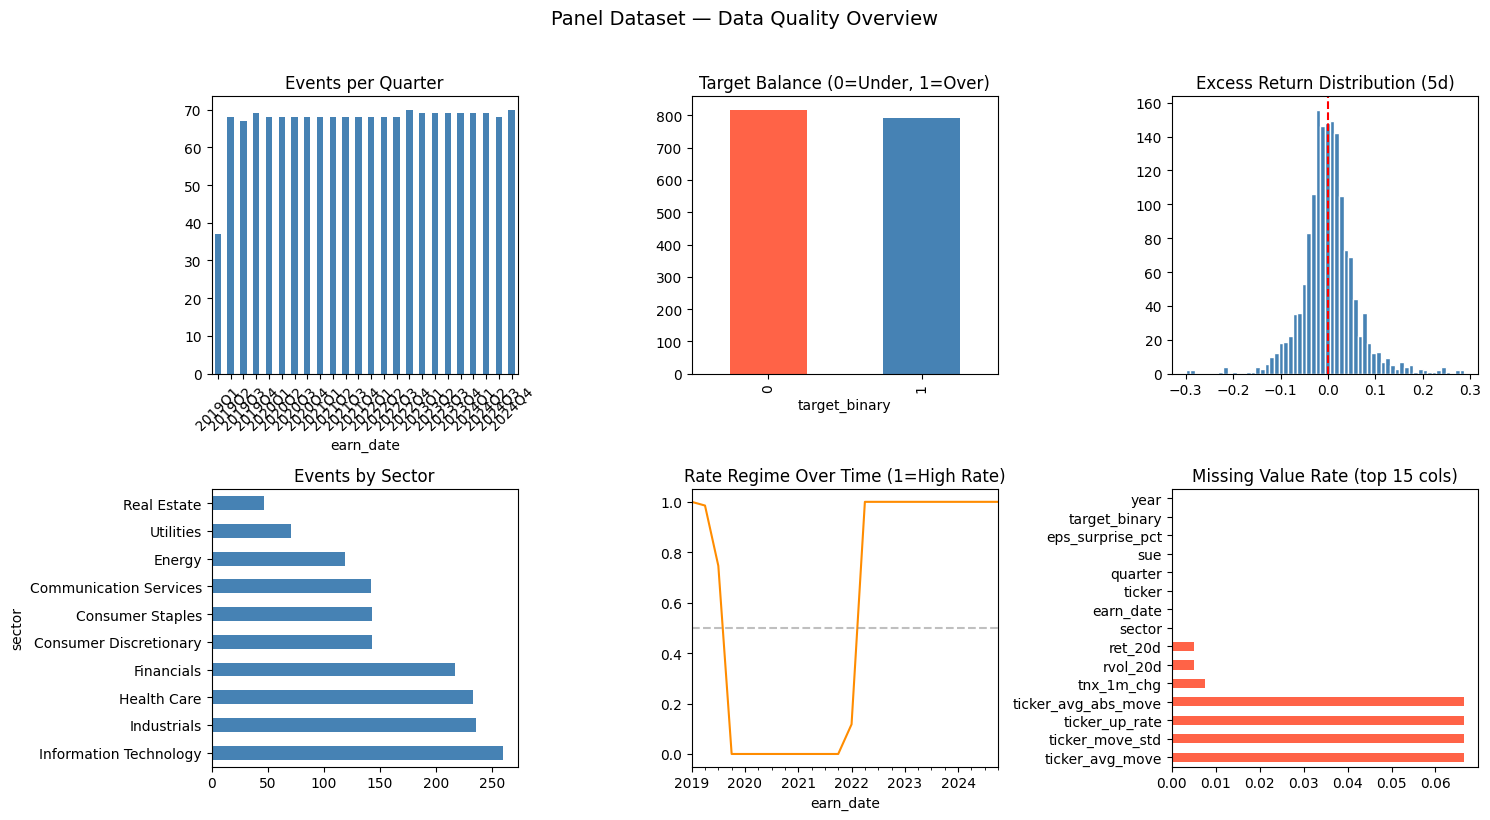

Plot saved to outputs/01_data_quality.png


In [46]:
# ── Step 6: Data quality check ────────────────────────────────
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Panel Dataset — Data Quality Overview', fontsize=14, y=1.02)

# Events over time
panel['earn_date'] = pd.to_datetime(panel['earn_date'])
panel.groupby(panel['earn_date'].dt.to_period('Q')).size().plot(
    ax=axes[0,0], title='Events per Quarter', kind='bar', color='steelblue'
)
axes[0,0].tick_params(axis='x', rotation=45)

# Target balance
panel['target_binary'].value_counts().plot(
    ax=axes[0,1], title='Target Balance (0=Under, 1=Over)', kind='bar',
    color=['tomato','steelblue']
)

# Excess return distribution
axes[0,2].hist(panel['excess_ret_5d'].clip(-0.3, 0.3), bins=60, color='steelblue', edgecolor='white')
axes[0,2].axvline(0, color='red', linestyle='--')
axes[0,2].set_title('Excess Return Distribution (5d)')

# Events per sector
panel['sector'].value_counts().plot(
    ax=axes[1,0], title='Events by Sector', kind='barh', color='steelblue'
)

# Rate regime over time
rate_by_q = panel.groupby(panel['earn_date'].dt.to_period('Q'))['rate_regime'].mean()
rate_by_q.plot(ax=axes[1,1], title='Rate Regime Over Time (1=High Rate)', color='darkorange')
axes[1,1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Missing value heatmap
missing = panel.isnull().mean().sort_values(ascending=False).head(15)
missing.plot(ax=axes[1,2], title='Missing Value Rate (top 15 cols)', kind='barh', color='tomato')

plt.tight_layout()
plt.savefig('../outputs/01_data_quality.png', dpi=150, bbox_inches='tight')
plt.show()
print('Plot saved to outputs/01_data_quality.png')